In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#For clustering
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

#For measuring
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score


# Data collection

In [8]:
df = pd.read_csv("32_fish.csv")
df.columns = df.columns.str.replace(' ', '')
df.head()

,body.length,head.length,width,weight,species
0,5.1,3.5,1.4,3.2,goldfish
1,4.9,3.0,1.4,3.2,goldfish
2,4.7,3.2,1.3,3.2,goldfish
3,4.6,3.1,1.5,3.2,goldfish
4,5.0,3.6,1.4,3.2,goldfish


# Data description

We will analyze and describe each of the columns of the dataset

### Species

Names of the different species existing

In [14]:
print("No of Unique Species: ",len(df.species.unique()))
print("Names of Unique Species: ",df.species.unique())


No of Unique Species:  3
Names of Unique Species:  ['goldfish' 'island_mackerel' 'Mugilidae']


In [17]:
print("Count of fishes for each Species:\n ",df.species.value_counts())

Count of fishes for each Species:
  species
goldfish           50
island_mackerel    50
Mugilidae          50
Name: count, dtype: int64


This column is well distributed, only having 3 species and they all appear the same number of times, showing 50 fishes of each specie

### Body.length

This column describes the length of the fish in a float value (we suppose centimeters or inches)

In [ ]:
df["body.length"].describe()

count    148.000000
mean       5.840541
std        0.832817
min        4.300000
25%        5.100000
50%        5.800000
75%        6.400000
max        7.900000
Name: body.length, dtype: float64

<Axes: >

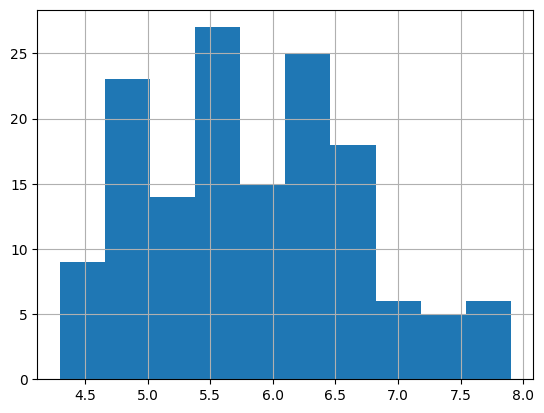

In [ ]:
df["body.length"].hist()

This column seems logic, with no outliers or weird values, having a low value of standard deviation

### Head.length

This column describes the length of the fish head in a float value (we suppose centimeters or inches)

In [ ]:
df["head.length"].describe()

count    149.000000
mean       3.052349
std        0.434583
min        2.000000
25%        2.800000
50%        3.000000
75%        3.300000
max        4.400000
Name: head.length, dtype: float64

<Axes: >

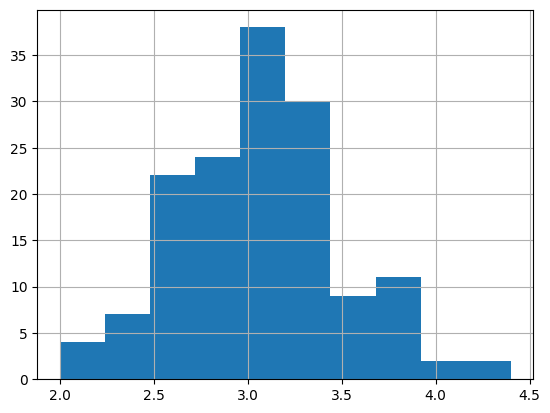

In [ ]:
df["head.length"].hist()

This column also seems correct, without outliers or interesting observations to highlight. A value between 3 and 3.5 is the most usual.

### Width

This column describes the with of the fish in a float value (we suppose centimeters or inches)

In [ ]:
df["width"].describe()

count    149.000000
mean       3.775168
std        1.758720
min        1.000000
25%        1.600000
50%        4.400000
75%        5.100000
max        6.900000
Name: width, dtype: float64

<Axes: >

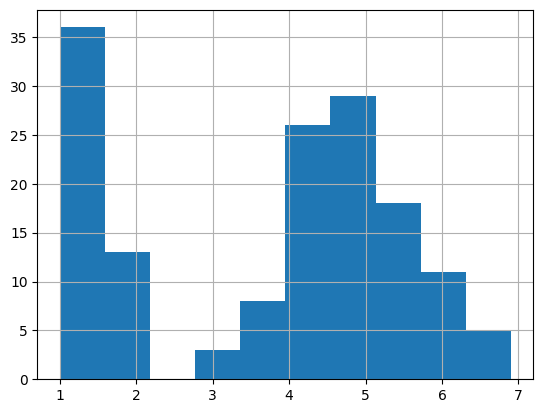

In [ ]:
df["width"].hist()

In this column, we can see a high standard deviation value, observed also in the histogram, where we see a group of values with a value lower than 2.5. Basing on this we suppose that one of the species is usually thiner than the others, creating this hole between values higher and lower than 2.5.

In [ ]:
df[df.width < 2.5].species.value_counts()

species
goldfish    49
Name: count, dtype: int64

As just exposed, we can confirm that goldfish is a species usually thin, making it easy to differentiate from the others.

### Weight

This column describes the weight of the fish in a float value (we suppose pounds or grams)

In [ ]:
df["weight"].describe()

count    148.000000
mean       1.878378
std        1.205009
min        0.100000
25%        0.500000
50%        2.000000
75%        3.200000
max        3.600000
Name: weight, dtype: float64

<Axes: >

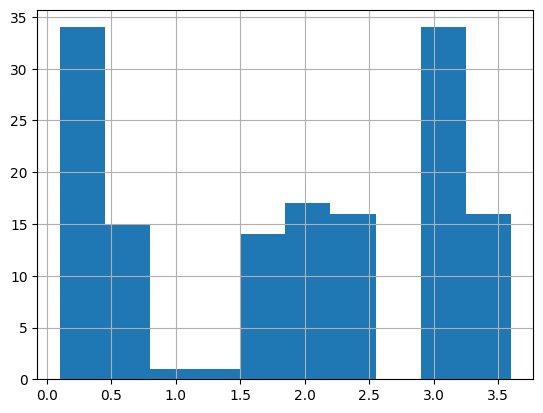

In [ ]:
df.weight.hist()

A similar situation as the one exposed in the with column can be found in the weight column. We can easily differentiate in the graph 3 groups, from 0 to 1.25, from 1.25 to 2.75 and heavier than 2.75. We will investigate as before.

In [ ]:
print(df[df.weight < 1.25].species.value_counts())
print(df[(df.weight > 2.75) & (df.weight > 1.25)].species.value_counts())
print(df[df.weight > 2.75].species.value_counts())

species
island_mackerel    50
Name: count, dtype: int64
species
goldfish    50
Name: count, dtype: int64
species
goldfish    50
Name: count, dtype: int64


Even some outliers were expected, with the aproximate values chosen we have perfectly divided the weights into 3 groups, 1 for each species.

# Data preprocessing

### Column transformation

We create unique integer codes for the column of species to deal with them easily as numbers.

In [ ]:
category_mapping = {category: i for i, category in enumerate(df['species'].unique())}
df['species_code'] = df['species'].map(category_mapping)
df

,body.length,head.length,width,weight,species,species_code
0,5.1,3.5,1.4,3.2,goldfish,0
1,4.9,3.0,1.4,3.2,goldfish,0
2,4.7,3.2,1.3,3.2,goldfish,0
3,4.6,3.1,1.5,3.2,goldfish,0
4,5.0,3.6,1.4,3.2,goldfish,0
...,...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Mugilidae,2
146,6.3,2.5,5.0,1.9,Mugilidae,2
147,6.5,3.0,5.2,2.0,Mugilidae,2
148,6.2,3.4,5.4,2.3,Mugilidae,2


In [ ]:
df = df.drop(["species"],axis=1)
category_mapping

{'goldfish': 0, 'island_mackerel': 1, 'Mugilidae': 2}

### NAN values

In [ ]:
df.isna().sum()

body.length     2
head.length     1
width           1
weight          2
species_code    0
dtype: int64

We can firstly see that the important column, assigning the species has no empty values. Then all the other columns have problems that have to be investigated and corrected.

As an easy solution, we have thought that filling those values with the mean of the specie might be an appropriate value easily appliable so that, if a goldfish does not have the height, the mean of the goldfish heights will be calculated and assigned so that it is representative.

In [ ]:
cols_to_fill = ['body.length', 'head.length', 'width', 'weight']

for col in cols_to_fill:
    df[col] = df.groupby('species_code')[col].transform(lambda x: x.fillna(x.mean()))

df.isna().sum()

body.length     0
head.length     0
width           0
weight          0
species_code    0
dtype: int64

# Data Analysis

Now that the dataframe is ready, we will start by finding some correlations in it.

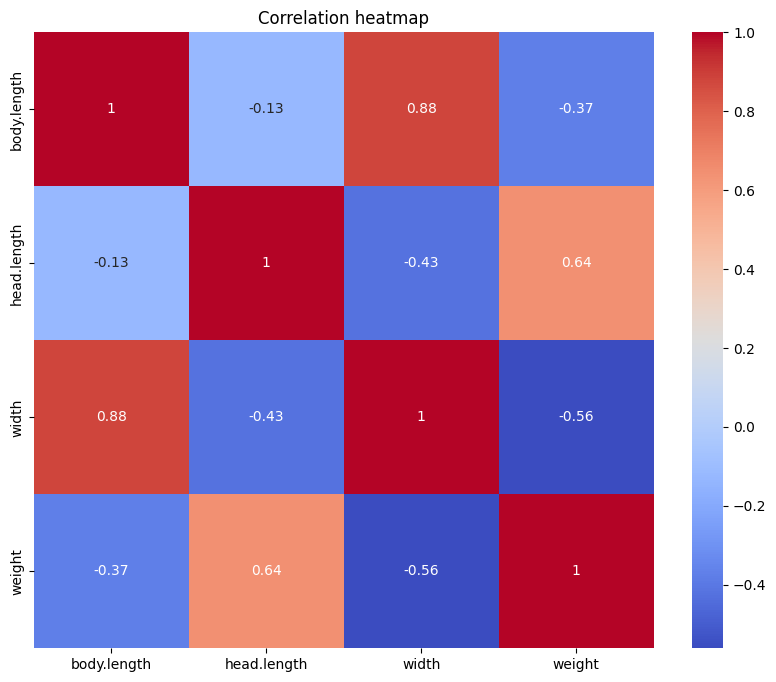

In [ ]:
correlation_matrix = df.drop(["species_code"],axis=1).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation heatmap')
plt.show()

The only correlation we can highlight on this correlation heatmap is the high relation between the body length and width, something that appears logical as if a fish is longer it will tend to be wider.

On the contrary, we can see that it is quite impresive the low correlations weights have with the column, as it is usually related to the size of the fish.

Now we can inspect each of the species and their internal correlations

Correlation matrix for species 0:


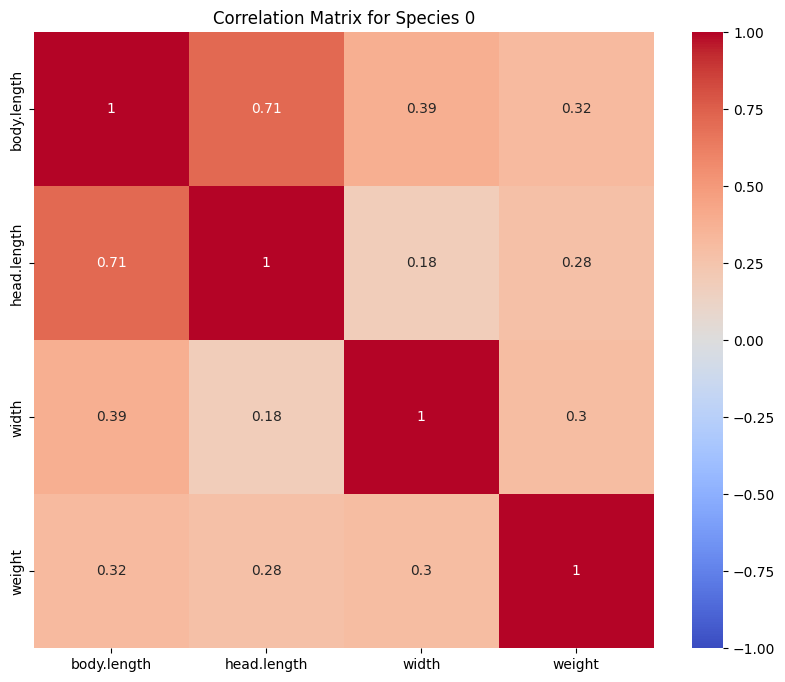

Correlation matrix for species 1:


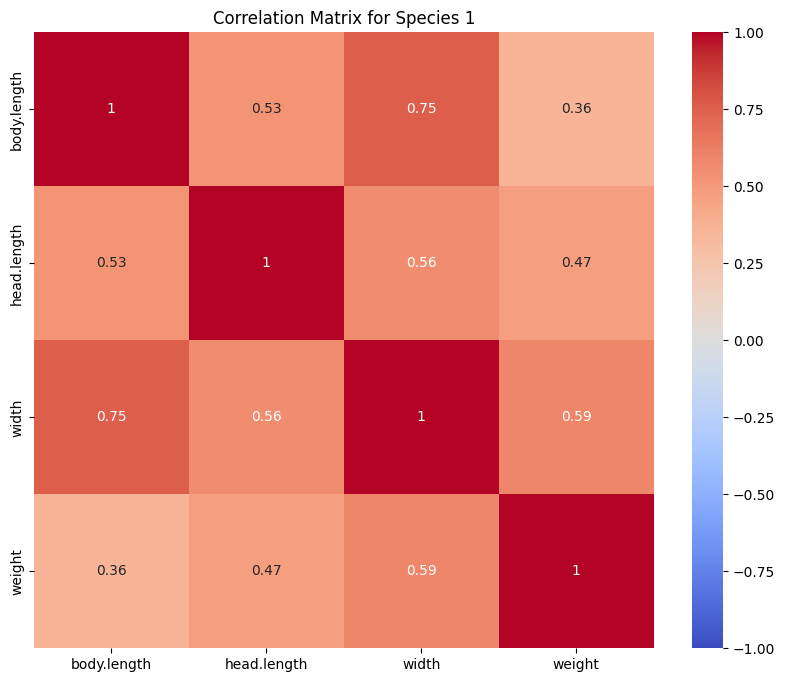

Correlation matrix for species 2:


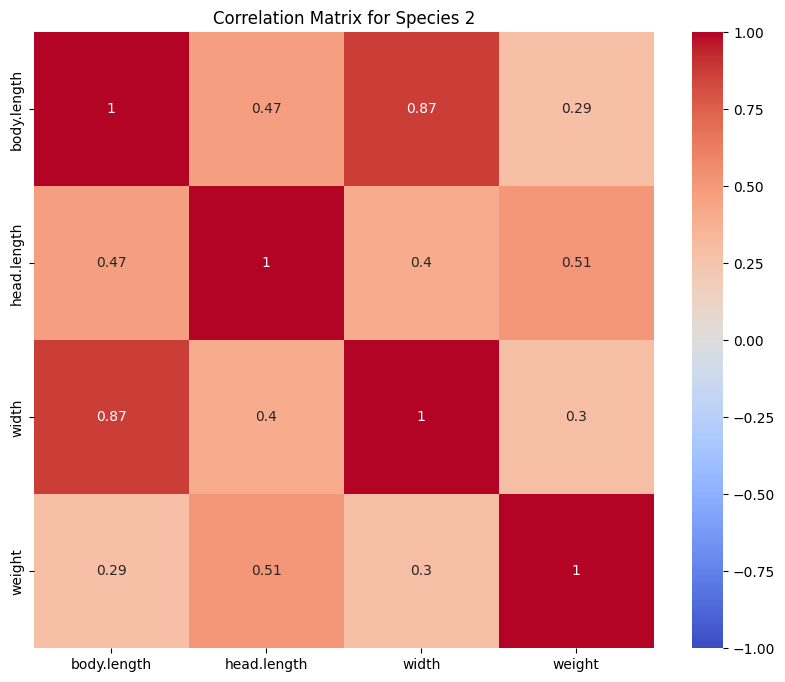

In [ ]:
for species in df['species_code'].unique():
    print(f"Correlation matrix for species {species}:")
    species_df = df[df['species_code'] == species]
    species_corr = species_df[cols_to_fill].corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(species_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title(f'Correlation Matrix for Species {species}')
    plt.show()


We can see, that for island_mackerel and Mugilidae, the only high correlation to be highlighted is the one exposed before. However, for the goldfish, we can see a high relation between the head and the body length. This also seems logical as the bigger the body is, the bigger the head will be, something that is not that highlighted in the other 2 species.

# Clustering

In this problem, as a first idea of a clustering algorithm, we are going to test how well can we classify the data in the 3 different species, just basing on the 4 characteristics of the fish. It is a basic idea that might help us to understand better the different groups and characteristics of the dataset.

To do so, we will firstly standardize the data.

In [ ]:
df_clustering = df.drop(columns=["species_code"])

In [ ]:
scaler = StandardScaler()
df_standarized = scaler.fit_transform(df_clustering)

Then we will use 2 different algorithms, the classic K-means and the hierarchical clustering, setting the number of clusters to 3 as we already know that there are 3 species.

In [ ]:
#K-means clustering
kmeans = KMeans(n_clusters=3)
kmeans.fit(df_standarized)
df['kmeans_cluster'] = kmeans.labels_

#Hierarchical clustering (Agglomerative Clustering)
agg_clustering = AgglomerativeClustering(n_clusters=3)
agg_clustering.fit(df_standarized)
df['hierarchical_cluster'] = agg_clustering.labels_

In [ ]:
#We create the 2 contingency tables to check the results
kmeans_contingency = pd.crosstab(df['species_code'], df['kmeans_cluster'], rownames=['Real value'], colnames=['K-Means Cluster prediction'])
hierarchical_contingency = pd.crosstab(df['species_code'], df['hierarchical_cluster'], rownames=['Real value'], colnames=['Hierarchical Cluster prediction'])

print(kmeans_contingency)
print(hierarchical_contingency)


K-Means Cluster prediction   0   1   2
Real value                            
0                            0   0  50
1                           50   0   0
2                            2  48   0
Hierarchical Cluster prediction   0   1   2
Real value                                 
0                                 0  50   0
1                                50   0   0
2                                 2   0  48


As we can see, both algorithms usually fail 1 or 2 predictions. This lets us know that there are 3 clear differentiable clusters or groups of data. Now we will see some representations to understand the results.

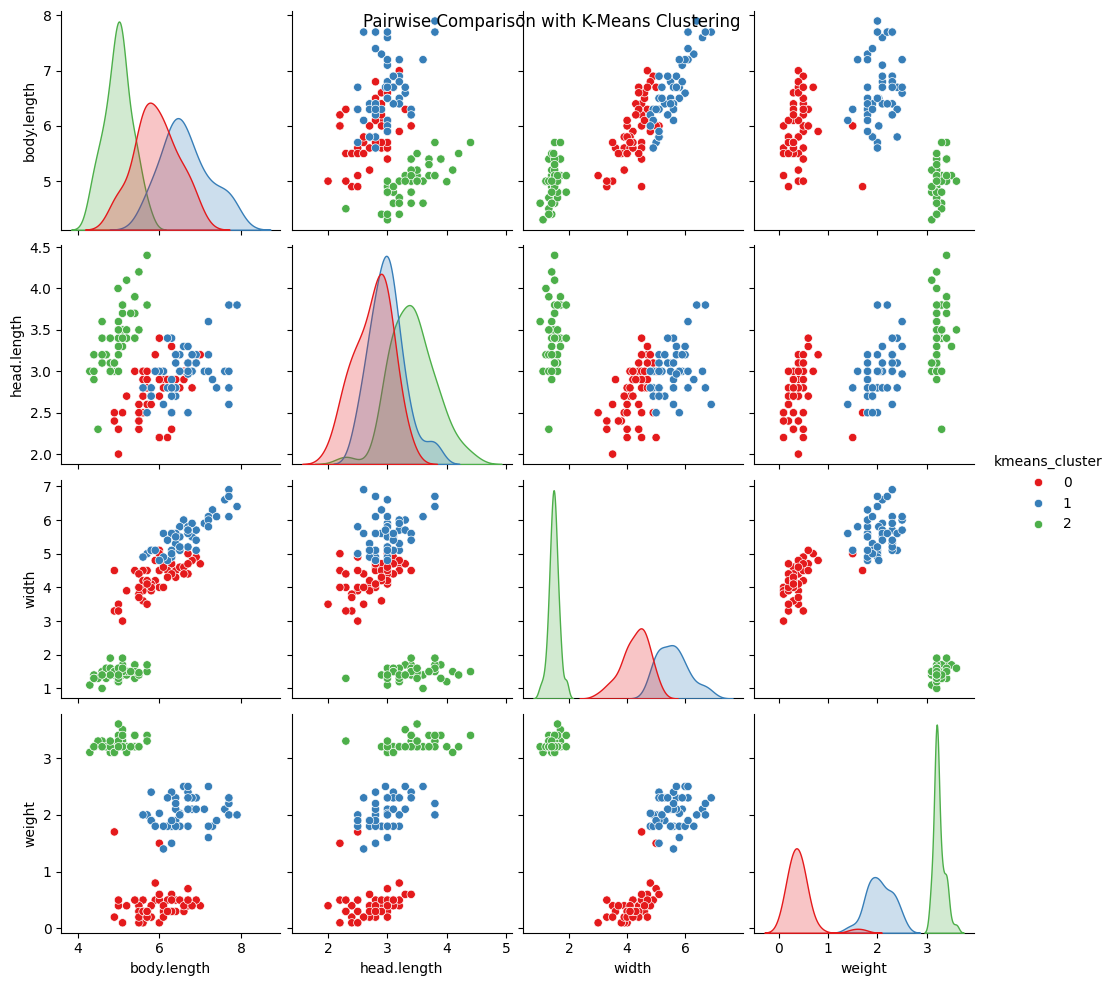

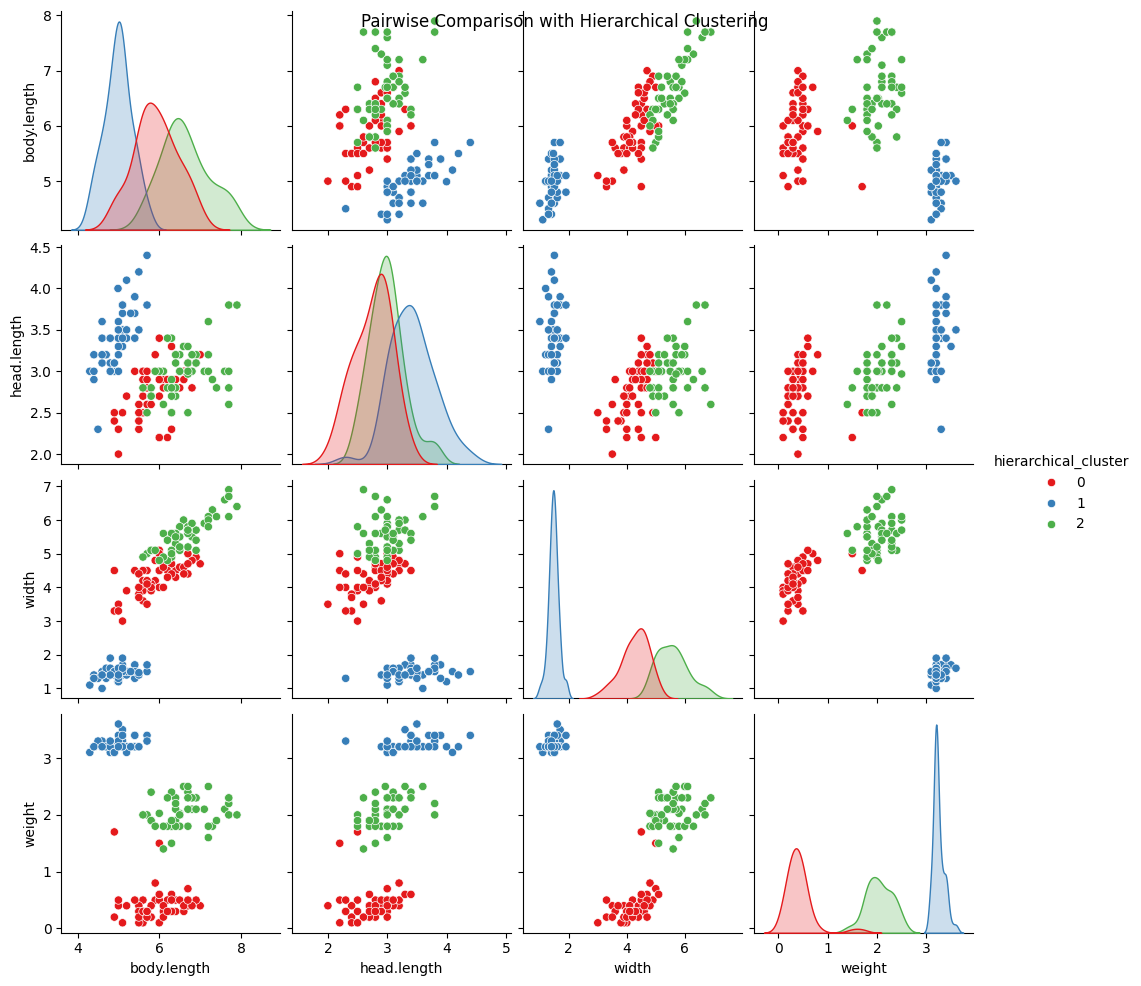

In [ ]:
# Create pair plot comparing variables with K-means clustering
sns.pairplot(df[['body.length', 'head.length', 'width', 'weight', 'kmeans_cluster']],
             hue='kmeans_cluster', palette='Set1', diag_kind='kde')
plt.suptitle('Pairwise Comparison with K-Means Clustering')
plt.show()

# Create pair plot comparing variables with hierarchical clustering
sns.pairplot(df[['body.length', 'head.length', 'width', 'weight', 'hierarchical_cluster']],
             hue='hierarchical_cluster', palette='Set1', diag_kind='kde')
plt.suptitle('Pairwise Comparison with Hierarchical Clustering')
plt.show()

As we can see in the graphs, the first idea that is easy to recognize, is the important value the weight have in this problem. In all comparisons, we can see that the 3 groups are clearly separated, indicating the big difference of weight the different species have. It is also notable that the blue group, class 1, is usually very differentiated of the others, easy to recognize, making it of a 100% accuracy in all trials.

Now that we have understood this, we will focus on finding the best number of clusters that fit the dataset and study the results obtained.

The first idea, is the use of the Elbow Method on Kmeans. This method is used to determine the most optimum number of clusters that should be used for clustering.

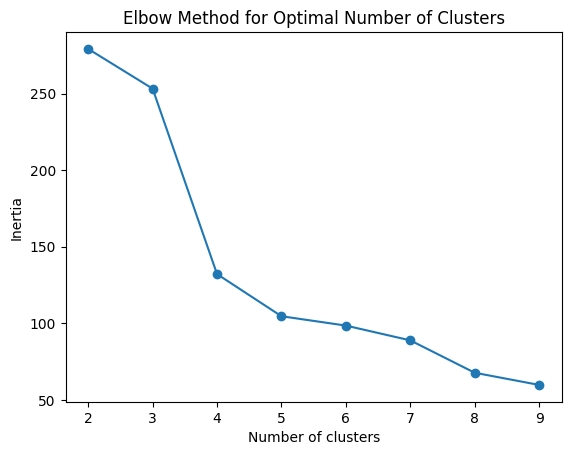

In [ ]:
num_clusters_range = range(2, 10)
inertia = []
for num_clusters in num_clusters_range:
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(df_standarized)
    inertia.append(kmeans.inertia_)

plt.plot(num_clusters_range, inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.show()

As we can see, ther is a clear elbow in the value of 4 clusters. This might be an appropiate value to try. Also 5 is a good option, as after that value the inertia stabilizes in the graph, so trying 6 or 7 does not look logic.

Before trying, we will se another famous methodology, the Silhouette method, which uses the coefficient of Silhouette. It might determine the best number of clusters for our dataset.

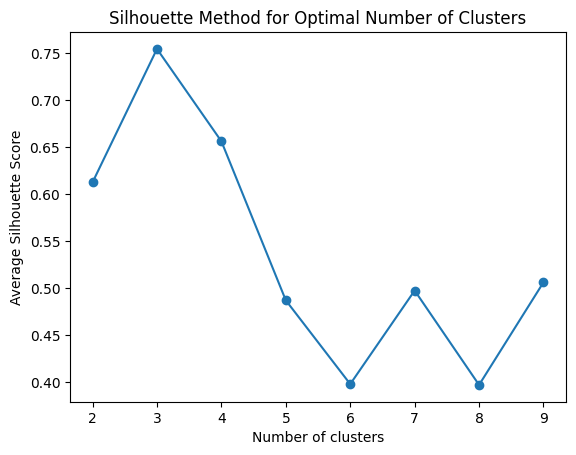

In [ ]:
num_clusters_range = range(2, 10)
silhouette_scores = []
for num_clusters in num_clusters_range:
    kmeans = KMeans(n_clusters=num_clusters)
    cluster_labels = kmeans.fit_predict(df)
    silhouette_avg = silhouette_score(df, cluster_labels)
    silhouette_scores.append(silhouette_avg)

plt.plot(num_clusters_range, silhouette_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Average Silhouette Score')
plt.title('Silhouette Method for Optimal Number of Clusters')
plt.show()

We can see that there is a high peak in the value of 3 clusters, as expected because is the classification of species we have worked in before. Also the 4 value again has a high value, so it is going to be the first one to be tried.

In [ ]:
#K-means clustering
kmeans = KMeans(n_clusters=4)
kmeans.fit(df_standarized)
df['kmeans_cluster'] = kmeans.labels_

#Hierarchical clustering (Agglomerative Clustering)
agg_clustering = AgglomerativeClustering(n_clusters=4)
agg_clustering.fit(df_standarized)
df['hierarchical_cluster'] = agg_clustering.labels_

In [ ]:
#We create the 2 contingency tables to check the results
kmeans_contingency = pd.crosstab(df['species_code'], df['kmeans_cluster'], rownames=['Real value'], colnames=['K-Means Cluster prediction'])
hierarchical_contingency = pd.crosstab(df['species_code'], df['hierarchical_cluster'], rownames=['Real value'], colnames=['Hierarchical Cluster prediction'])

print(kmeans_contingency)
print(hierarchical_contingency)


K-Means Cluster prediction   0   1   2   3
Real value                                
0                            0  21  29   0
1                            0   0   0  50
2                           48   1   0   1
Hierarchical Cluster prediction   0   1   2   3
Real value                                     
0                                50   0   0   0
1                                 0  19   0  31
2                                 0   2  48   0


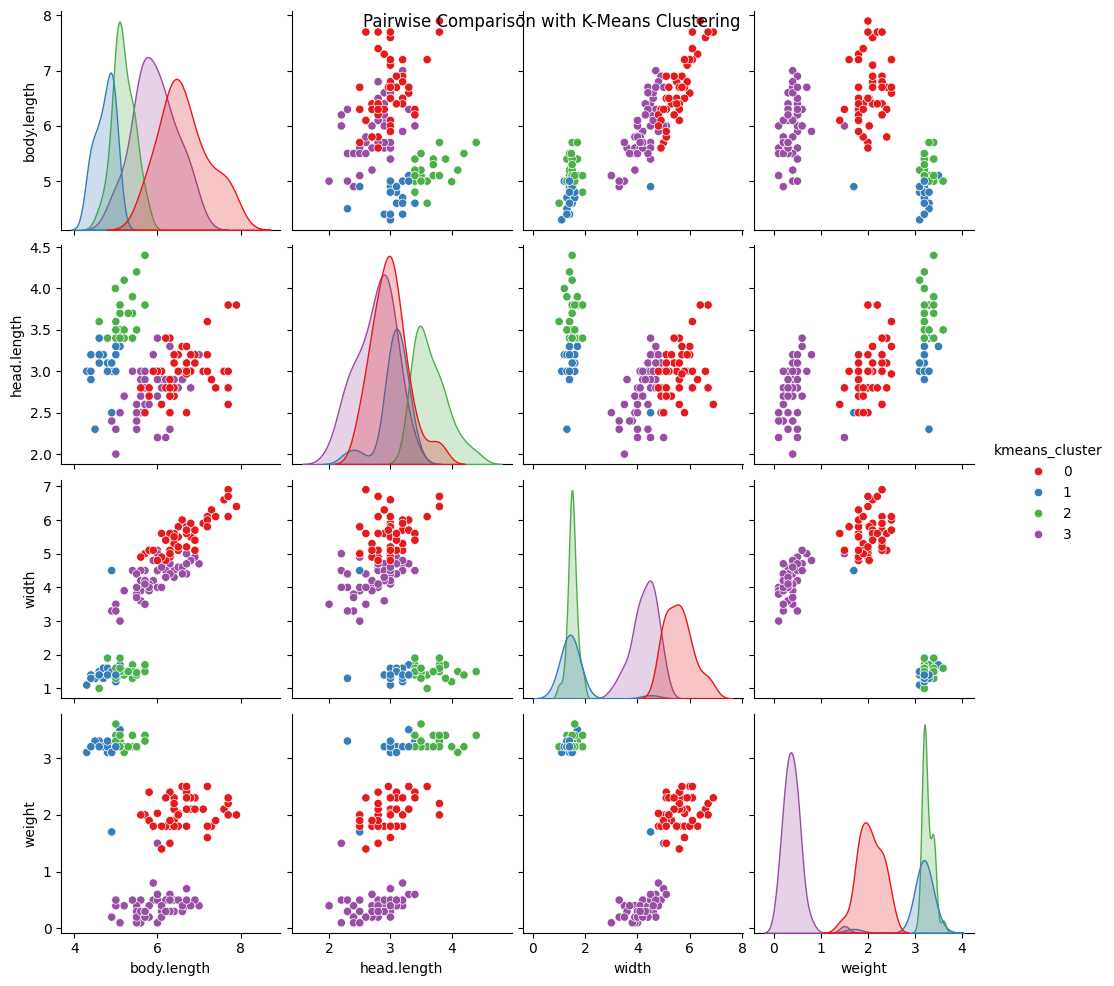

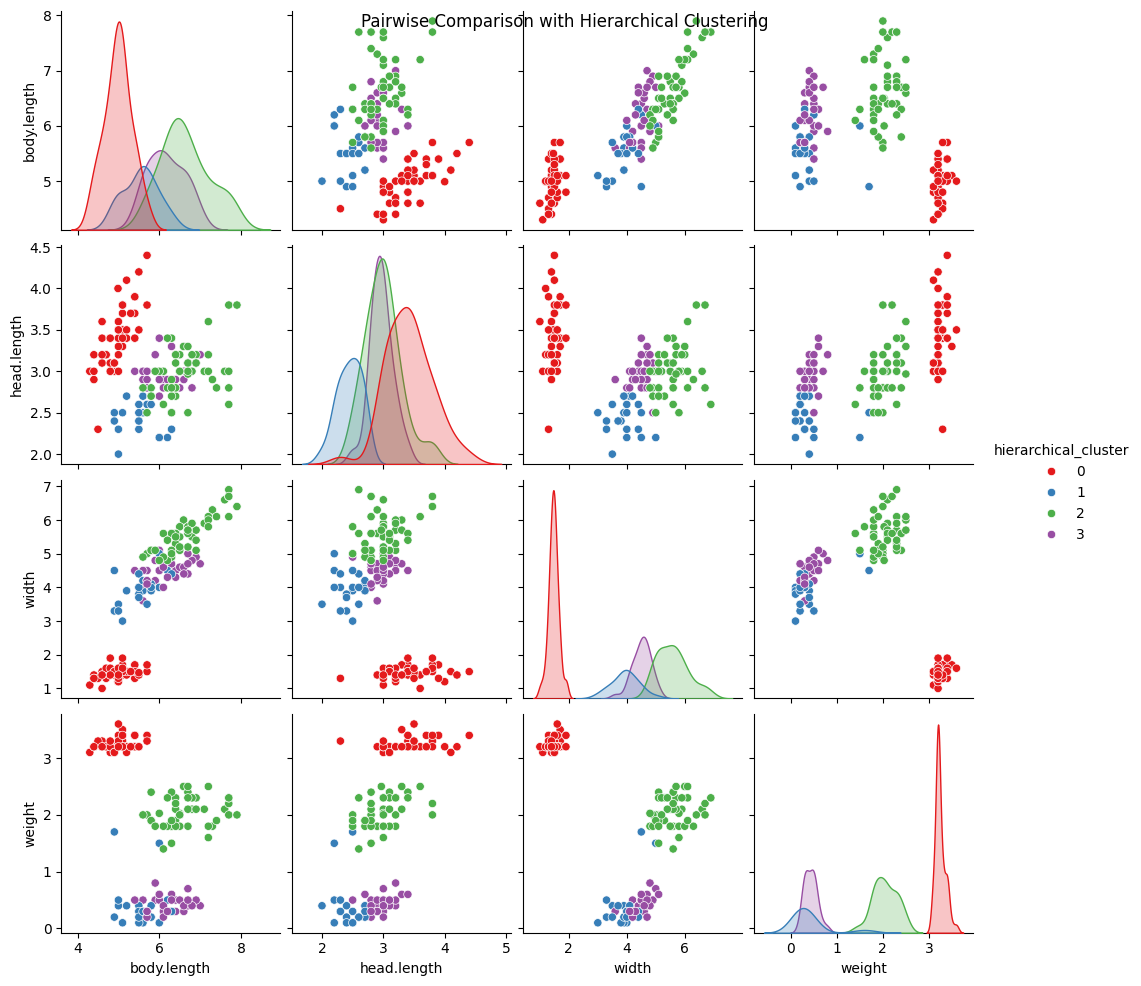

In [ ]:
# Create pair plot comparing variables with K-means clustering
sns.pairplot(df[['body.length', 'head.length', 'width', 'weight', 'kmeans_cluster']],
             hue='kmeans_cluster', palette='Set1', diag_kind='kde')
plt.suptitle('Pairwise Comparison with K-Means Clustering')
plt.show()

# Create pair plot comparing variables with hierarchical clustering
sns.pairplot(df[['body.length', 'head.length', 'width', 'weight', 'hierarchical_cluster']],
             hue='hierarchical_cluster', palette='Set1', diag_kind='kde')
plt.suptitle('Pairwise Comparison with Hierarchical Clustering')
plt.show()